# Neural Network project, 2022
## - Artist similarity with Graph Neural Networks (re-implementation)
- Andrea Giuseppe Di Francesco, 1836928
- Giuliano Giampietro, 2024160

* In this notebook we present a complete re-implementation of the paper ['Artist similarity with Graph Neural Network'](https://arxiv.org/abs/2107.14541). 
* Since the project's code wasn't provided by the authors, except for the [dataset](https://gitlab.com/fdlm/olga://paperswithcode.com/paper/artist-similarity-with-graph-neural-networks), we attempted to repeat the experiments described in the paper, and we have additionally tried 4 additional GNNs architectures, provided by the Phd student Indro Spinelli.


## - Importing the libraries

In the following cell we import the libraries that we used to carry out our experiments, and to extract the dataset. Since we worked with the Graph Neural Networks (GNN), it was very helpful to use the [pytorch geometric library](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html), that contains a lot of useful classes that implement the most famous GNNs architectures.

In [35]:
# !pip install plotly
# !pip install musicbrainzngs
# !pip install torchmetrics
# !pip install spacy-sentence-bert
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)
# !pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

1.13.0


In [36]:
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import json
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
from torchmetrics.functional import pairwise_euclidean_distance
# from torch_geometric.nn import GATConv, SAGEConv
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import lr_scheduler
import random
from random import choice,randrange
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
import math
import time
# from torch_geometric.nn import GCNConv,GraphConv,GATConv,SAGEConv
import musicbrainzngs as mbr
import spacy_sentence_bert

random_seed=80085

random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)

In [ ]:
sentence_selector = spacy_sentence_bert.load_model('en_stsb_roberta_base')

In [60]:
sentence_selector('classical rock').similarity(sentence_selector('classical music'))

0.7326302253062094

In [49]:
for k in ol.occurrencies:
    print(k, ol.occurrencies[k])

black metal 7
blackgaze 1
post-punk 12
2008 universal fire victim 62
soul 49
00s 3
10s 2
80s 8
90s 6
country 26
electronic 59
english 45
european 11
folk 66
french 17
latin 29
multiple ipi 1
punk 29
rap 5
reggae 10
rock 159
spanish 3
world 7
new wave 26
synthpop 21
death metal 12
metal 33
poland 2
technical death metal 2
drum and bass 10
slummin 1
alternative rock 58
pop punk 10
bebop 3
cool jazz 4
jazz 97
brazilian metal 1
death-metal 1
alternative hip-hop 1
american 54
hip-hop 4
classic pop and rock 53
ccm 1
contemporary gospel 2
contemporary r&b 28
dance-pop 17
electropop 9
gospel 7
blues 32
classic country 1
country blues 5
country gospel 1
hillbilly 1
honky tonk 3
poetry 4
rockabilly 4
traditional country 2
folk punk 3
hip hop 75
ambient 23
dark pop 1
drone 7
jam band 6
krautrock 6
neo psychedelia 1
psychedelic rock 15
space rock 5
breakbeat hardcore 1
jungle 3
rave 2
rock and indie 35
big beat 4
breakbeat 2
dutch 5
electroclash 3
film score 3
film soundtrack 2
2000s 6
jazz pop 4


## Loading of the dataset Olga

 - In the next cell there is the raw dataset provided by the paper's authors **'Artist similarity with Graph Neural Networks'**.
 - Along the columns we have information about the [Musicbrainz_id](https://musicbrainz.org/) of an artist, its partition in the dataset (train,val,test), and the [AcousticBrainz](https://acousticbrainz.org/) low level features of the artist, taken from a sample of 25 songs. 
 - Unfortunately, at the best of our efforts, it was not possible to recover all the information that were described in the [paper](https://arxiv.org/pdf/2107.14541.pdf). Indeed the artists contained in Olga are 17.673, whereas we were able to extract [Allmusic](https://www.allmusic.com/) ids only from 11.261 artists. 



In [7]:
olga=pd.read_csv('olga.csv')
#train 0-14138, #val 14139-15905, #test 15906-17673 (indices)
olga[:30]

mbr.auth('ggiamp', 'fallinggiant')
mbr.set_useragent(
    "python-musicbrainzngs-example",
    "0.1",
    "https://github.com/alastair/python-musicbrainzngs/",
)

### How do we retrieve the Graph topology?

- Thanks to the musicbrainz_id of each artist, we can get the link to its AllMusic profile, and from there we get also the information about its related artists. Each AllMusic link is related to a unique artist, indeed we can spot a 12 numbers identifier for each of these.
- After having obtained the AllMusic link for each artist in the dataset (if exists), we want to associate to each artist its related ones. We do this just for those that can be re-mapped in the dataset's musicbrainz_ids, because we have associated tracks features for those.
- Also this passage is probably very lossy, in fact, for each artist there could be a lot of similar artists (according to the AllMusic information), but we don't have the feature vectors for all of them.
- The following class contains methods that extract information about all the artists in the dataset, but the price to pay is a high computational cost. 
For this reason it was run just once, and the information was stored in different files, such as 'MsbMapped.json', 'graphSimilarities.json', 'dizofartist.json'.

In [32]:
class DatasetOlga(): #In this class, we obtain through different methods the main characteristics of the graph of artists
                    # thanks to the available information in the olga dataset
    def __init__(self,olga):
        self.olga=olga
        self.mb=olga.musicbrainz_id
        self.artists={} #Needed for obtaining the mapping from musicbrainz to the allmusic ids
        self.l=len(self.mb)
        self.d={}       #Needed for obtaining a dict. where keys are artists, and values are the artists similar to them, based on self.artists
        self.NI={}      #Dict. that will contain the artist's features
    
    def get_mapping(self,i):                                                                                                 #This method returns the allmusic page of an artist (if exists), given his id from the dataset 
        response = requests.get(f'https://musicbrainz.org/ws/2/artist/{str(self.mb[i])}?inc=url-rels&fmt=json')
        if response.ok:
            data = response.json()
            refs = [r['url']['resource'] for r in data['relations'] if r['type'] == 'allmusic']        
            return refs[0] if len(refs) != 0 else "Not found"

    def get_artist_name(self,i):                                                                                                 #This method returns the allmusic page of an artist (if exists), given his id from the dataset 
        response = requests.get(f'https://musicbrainz.org/ws/2/artist/{str(self.mb[i])}?inc=url-rels&fmt=json')
        if response.ok:
            data = response.json()
            data = dict(data)
            return data['name']



    def get_mappingList(self,init,end,increm=500):
        Lmusicbrainz_id=self.mb[init:end] #We can specify the range of the artists of our interest, for the purpose of this NN task
        length=len(Lmusicbrainz_id)       #we will take all of them into consideration.
        c=0
        for i in range(len(Lmusicbrainz_id)):
            mapp=self.get_mapping(i)   #get_mapping method again.
            if mapp==None:
                while mapp==None:
                    mapp=self.get_mapping(i)
                    
            if mapp!="Not found":   #Some of the ids has not a respective allmusic id, so we lose that information
                mapp=str(mapp)      #Mapp are strings of links
                key=mapp[-12:]
                self.artists[key]=i
            c+=1
            if c%increm==0 or c==30:
                    print("{}/{} artists were processed".format(c,length)) #This is just to keep track of the processed artist
                    
            
        self.save_data(self.artists,'MsbMapped1.json')  #We do save the Artists Ids map, this function, when called, takes a lot
                                                        #of time, for this reason its result is already saved in the file:
        return self.artists                             # 'MsbMapped1.json'
    
    
    def get_GraphDict(self,name='MsbMapped.json',increm=500):
        session=HTMLSession()
        c=0 #Counter
        artID=self.load_data(name) #We load the mapped artists (between MusicBrainz Ids, and AllMusic Ids)
        # print(len(artID)
        length=len(artID.keys())
        for k in artID.keys(): #dict of mapped mbids, this has to be computed before from getmapping
            if k!=None:
                url='https://www.allmusic.com/artist/'+ k+ '/related' #k is just the code, every link for the artist is distinguished 
                r=session.get(url)                                    #by a unique code in the link.
                sess=r.html.find('body',first=True)
                div=sess.find('.overflow-container')                  #The information of the related artists are exctracted
                divn=div[0]                                           #from the html of the allmusic's related web page
                divn=divn.find('.content-container')
                divn=divn[0]
                divn=divn.find('.content')
                divn=divn[0]
                divn=divn.find('section',first=True)
                if divn==None:
                    self.d[artID[k]]=[] #That artist has not related artists (or we have missing information)
                    continue
                artists=divn.find('li')
                artistL=[]


                for i in range(len(artists)):
                    art=artists[i]
                    art=art.find('a')            #We look for all the k's related artists links
                    link=list(art[0].absolute_links)[0] #Absolute_link returns a one-element set, that we convert into a list and
                    link=str(link)[-12:]                #we get its code
                    if link in artID.keys(): #g is the dict of all the mapped musicbrainz_ids
                        artistL.append(self.artists[link]) #Some of the related artists may not be in the musicbrainz_ids list.
                self.d[artID[k]]=artistL
                c+=1
                if c%increm==0 or c==30:
                    print("{}/{} artists were processed".format(c,length))
        self.save_data(self.d,'graphSimilarities1.json') #Here we save the connection amongst the artists, obtained with this method
        print("Done...")     #Also it takes some time to process, for this reason the result of this method can be 
        return self.d        #found at the 'graphSimilarities.json' file.

    def get_genres(self,name='MsbMapped.json',increm=500):
        
        c=0 #Counter
        artID=self.load_data(name) #We load the mapped artists (between MusicBrainz Ids, and AllMusic Ids)
        valid_ids = sorted(list(artID.values()))
        self.occurrencies = {}
        self.artist_genre = {}
        print('Num of artist: {}', len(valid_ids))
        self.lost = 0
        for artist_num in range(len(valid_ids)):
          print(len(self.occurrencies))
          print('Artist {}/{}'.format(artist_num, len(valid_ids)))
          art_id = self.olga.iloc[valid_ids[artist_num], 1]
          result = mbr.get_artist_by_id(art_id,
              includes=['tags'])
          
          if 'tag-list' in result['artist']:
            genre_list = [genre['name'] for genre in result['artist']['tag-list']]
            self.artist_genre[artist_num] = genre_list, result['artist']['name']
            for genre in genre_list:
              if genre not in self.occurrencies:
                self.occurrencies[genre] = 1
              else:
                self.occurrencies[genre] += 1
          else:
            self.lost += 1
            print('Lost artist {}'.format(self.lost))
            self.artist_genre[artist_num] = [], result['artist']['name']


        return 

    def get_artist_genres(self,name='MsbMapped.json',increm=500):
        c=0 #Counter
        artID=self.load_data(name) #We load the mapped artists (between MusicBrainz Ids, and AllMusic Ids)
        valid_ids = sorted(list(artID.values()))
        return artID
    
    def save_data(self,dicti,name):
        jfile = open(name, "w")
        jfile = json.dump(dicti, jfile)
    
    def load_data(self,name):
        jfile = open(name, "r")
        dicti = json.load(jfile)
        return dicti
ol = DatasetOlga(olga)

In [33]:
ol.get_genres()

Num of artist: {} 11261
0
Artist 0/11261
Lost artist 1
0
Artist 1/11261
3
Artist 2/11261
5
Artist 3/11261
23
Artist 4/11261
Lost artist 2
23
Artist 5/11261
Lost artist 3
23
Artist 6/11261
25
Artist 7/11261
29
Artist 8/11261
30
Artist 9/11261
31
Artist 10/11261
33
Artist 11/11261
36
Artist 12/11261
38
Artist 13/11261
Lost artist 4
38
Artist 14/11261
41
Artist 15/11261
42
Artist 16/11261
48
Artist 17/11261
48
Artist 18/11261
Lost artist 5
48
Artist 19/11261
57
Artist 20/11261
Lost artist 6
57
Artist 21/11261
58
Artist 22/11261
59
Artist 23/11261
Lost artist 7
59
Artist 24/11261
67
Artist 25/11261
71
Artist 26/11261
71
Artist 27/11261
71
Artist 28/11261
77
Artist 29/11261
Lost artist 8
77
Artist 30/11261
83
Artist 31/11261
83
Artist 32/11261
84
Artist 33/11261
86
Artist 34/11261
Lost artist 9
86
Artist 35/11261
87
Artist 36/11261
88
Artist 37/11261
Lost artist 10
88
Artist 38/11261
92
Artist 39/11261
92
Artist 40/11261
92
Artist 41/11261
93
Artist 42/11261
Lost artist 11
93
Artist 43/1126

KeyboardInterrupt: 

## Graph construction

- Once we have obtained the information necessary to construct the Graph topology, and stored them into two json files ('MsbMapped.json','graphSimilarities.json'), we still need to have the Graph data structure to feed the Graph Convolutional Network.

- In the following cell are defined the graph's adjacency matrix from the 'graphSimilarities.json', which was previously obtained, and the features of each artist, namely the attributes of the graph's nodes. Those are obtained from a numpy array stored in the file 'acousticbrainz.npy', such file was provided by the paper's authors.

In [17]:
n_features=2613
class Graph():  #The purpose of this class is to construct the graph of artists, in particular the Adjacency matrix A, and the  
                # node features tensor X
        
    def __init__(self,mapfile,gfile):  #The expected files are the ones mentioned before.
        self.mfile=self.load_data(mapfile)
        self.gfile=self.load_data(gfile)
        self.ol = DatasetOlga(olga)
        self.A=torch.zeros((len(self.mfile),len(self.mfile)))
        self.X=torch.zeros((n_features,len(self.mfile)))
        self.ord=sorted(list(map(int,self.gfile.keys())))
        self.enc1={}
        self.enc2={}
    
    #With the preprocessing step at the previous cell we have lost some information
    #and also the ordering of the artists, so i have defined a method that for each previous artist index
    #we can encode it to a new ordered list of artists.
    
    
    def encoding1(self):   #From ordered to unordered, Dict are not ordered data structures, so is better to order them before
        for k in range(len(self.mfile)): #This encoding is used to get the Instance matrix
            self.enc1[k]=self.ord[k]
        return self.enc1
    
    def encoding2(self):   #From unordered to ordered,  From real number, to ordered one.
        for k in range(len(self.mfile)): #This encoding is used to get the Adjacency matrix
            self.enc2[self.ord[k]]=k
        return self.enc2
    
    def get_instance(self,instances,df=False):#We take the features centroid, obtained from 25 track from artists discographies.
        X=np.load(instances)                  #The instances file is provided by the repository mentioned in the paper.
        X=torch.from_numpy(X).requires_grad_(True) #We take the allmusicIDs, which contain the key of the artists for which we haven't 
        c=0                                        # lost information
        enc=self.encoding1()
        for k in self.mfile:
            z=enc[c]
            self.X[:,c]=X[z] 
            c+=1
        return self.X
    
    def get_adjacency(self,symmetry=False,df=False):  #The hypothesis could be either a symmetric matrix (paper), or not.
        enc=self.encoding2()
        for k in self.gfile:
            c1=enc[int(k)]
            for j in self.gfile[k]:
                c2=enc[int(j)]
                if self.A[c2,c1]==1 and symmetry==True:
                    continue
                self.A[c1,c2]=1
                if symmetry:
                    self.A[c2,c1]=1

            
        return self.A
    def get_artist_dict(self):
      self.id_to_art = {}
      for key in self.enc1:
        self.id_to_art[key] = self.ol.get_artist_name(self.enc1[key])
        print(key)


    def load_data(self,name):
        jfile = open(name, "r")
        dicti = json.load(jfile)
        return dicti
    
g=Graph('MsbMapped.json','graphSimilarities.json')
X1=g.get_instance('acousticbrainz.npy')
A1=g.get_adjacency(symmetry=True)

## diz_of_artist contains a mapping from the ids to the artists ##
diz_of_artist = ol.load_data('dizofartist.json')

## art_to_code is the opposite of diz_of_artist ##
art_to_code = {diz_of_artist[key]:key for key in diz_of_artist}
## The artists names are used to see how much the different artists are distant, and also to see what are their actual names, instead of their vectors.

NameError: ignored

In [ ]:
torch.save(A1,'adjacency')

In [ ]:
samples = np.array(torch.sum(A1,dim=1))

In [ ]:
samples = np.array(torch.sum(A1,dim=1))
fig=go.Figure()
fig.add_trace(go.Box(y=samples,boxpoints = 'all',
                    fillcolor="blue",jitter = 0.3,whiskerwidth = 0.1,boxmean = 'sd', marker_color = 'red',name = 'Artist distribution'))
fig.update_layout(title_text = 'Artists box plot',width=650)

fig.show()

# GraphSAGE model

- Once we also have the features for each instance, and the adjacency matrix of the graph, we can start to design the Graph Convolutional Layers, and the Fully Connected layers, as described in the paper.

- Every feature vector has 2613 elements (low level features of the artists), our aim is to embed these vectors in a 100-dimensional space, where the distance between its points (Euclidean distance) represents a musical distance among the artists. (It is not clear however what each dimension stands for).
The Graph Neural network attempts to learn this embedded space.

- The GraphNN that the paper's authors decided to use is the GraphSAGE model (SAGE stands for Sample and AGgregatE).



- This approach proposes a framework that generalizes the GCN to use trainable aggregation functions (beyond simple convolutions). ![Alt text](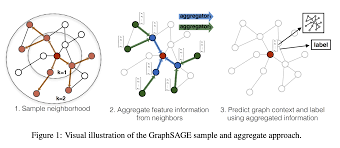 "GraphSAGE structure")
- This type of approach was introduced in the paper ['Inductive Representation Learning on Large Graphs'](https://arxiv.org/abs/1706.02216), that is also where it was taken the previous image.

In [ ]:
class GraphSAGE(nn.Module):
    
    def __init__(self,X,A,train_set,test_set,L,batch_size,device, training_mode = True):
        
        super(GraphSAGE,self).__init__()
        self.device=device
        self.A=A.to(self.device) #Tensors version of adjacency matrix and Instances
        ## There are two types of adjacency matrix that could be useful ##
        self.Atrain=self.select(self.A,train_set,train_set).to(self.device)
        self.ATot=self.select(self.A,train_set+test_set,train_set+test_set).to(self.device)
        
        self.feat=100
        self.X=torch.tensor(X.tolist(),requires_grad=True).to(self.device)   
        self.COO=torch.load('COOA.pt') #This file contains the whole adjacency matrix in coordinate format (which is the torch geometric format)
        self.train=train_set
        self.test=test_set
        self.L=L   #Number of layers
        self.lamb=0.8  #Percentage used for the weighted distance to choose the hard positives and the hard negatives.
        if training_mode:  #When we train we use this setting, otherwise is faster to set training_mode to false, in the case we want to carry out a forward on a batch of samples. 
          self.bs=batch_size
          self.diz=self.getDiz()
          self.mb=self.mini_batches(self.train+self.test,self.bs)
          self.OrDiz=self.getCorrenspondancies(self.mb)
        self.SG1=SAGEConv(2613,256,normalize=True,aggr="mean")
        self.SG2=SAGEConv(256,256,normalize=True,aggr="mean")
        self.SG3=SAGEConv(256,256,normalize=True,aggr="mean")
        
        self.FC1=nn.Linear(256,256)
        self.FC2=nn.Linear(256,256)
        self.FC3=nn.Linear(256,self.feat)
        self.FC4 = nn.Linear(256,256)
        
    def forward(self,V,b,nbs=-1,eval_mode = False):
        Vdiz=self.tracing(V,b, eval_mode)
        
        # If these statements hold it means that we have already defined the mini batches for the training data, and we don't have to look for their 
        # neighbors everytime. Otherwise we get the neighbors for them.
        if len(V)>500 and nbs!=-1:
            OrDiz=self.OrDiz[nbs]
        else:
            OrDiz=self.getCorr(Vdiz) #Every sample/artist is normalized from 0 to 512(batch_size), in order to get easily the indices from the matrix A.
            
        for k in range(0,self.L):  #k reach maximum 2, the precise number depends on the number of layers that we decide to use for the GraphSAGE's models
            

            if k==0:
                Es=self.select(self.X,set(),Vdiz[k+1]).T
                Anew=self.select(self.A,Vdiz[k+1],Vdiz[k+1])
                Anew=self.ConvertAtoCOO(Anew)
                Es=self.SG1(Es,Anew).T
                Es=F.elu(Es)
    
            if k==1:
                Es=self.select(Es,set(),OrDiz[k+1].keys()).T
                Anew=self.select(self.A,Vdiz[k+1],Vdiz[k+1])
                Anew=self.ConvertAtoCOO(Anew)
                Es=self.SG2(Es,Anew).T
                Es=F.elu(Es)
                
            
            if k==2:
                Es=self.select(Es,set(),OrDiz[k+1].keys()).T
                Anew=self.select(self.A,Vdiz[k+1],Vdiz[k+1])
                Anew=self.ConvertAtoCOO(Anew)
                Es=self.SG3(Es,Anew).T
                Es=F.elu(Es)
                
            
            if k==self.L-1:
                Es=self.select(Es,set(),OrDiz[k+2]).T
            
            
        out=self.FC1(Es)
        out=self.FC2(out)
        out=self.FC3(out)
        return out.T
    
    def getCorrenspondancies(self,mbb):  ## If we are training the normalization of the batch samples is done from the pre-computed mini-batches ##
        OrDiz={}
        num=int(len(self.train)/self.bs)+1
        for j in range(len(mbb[:num])):
          Vdiz=self.tracing(mbb[j],1)
          OrDiz[j]={}
          for k in Vdiz:
              OrDiz[j][k]={}
              OrDiz[j][k]={i: sorted(list(Vdiz[k]))[i] for i in range(len(Vdiz[k]))}
          print("Processed {}-th mini-batch".format(j+1))
        return OrDiz
    
    def getCorr(self,Vdiz): 
        OrDiz={}
        for k in Vdiz:
            OrDiz[k]={}
            OrDiz[k]={i: sorted(list(Vdiz[k]))[i] for i in range(len(Vdiz[k]))}
        return OrDiz
            
            
    
    def tracing(self,V,b,eval_mode = False):  # To perform the FFW in the Graph Networks we need to trace the neighbors for each samples. 
        Vdiz={}                               # This is done through this method and with the 'get_n' method
        K=self.L+1
        Vdiz[K]=sorted(list(V))
        for k in range(K-1,0,-1):
            d=set()
            for idx in Vdiz[k+1]: 
                d=d.union(self.get_n(idx,b, eval_mode))
                
            Vdiz[k]=d
        return Vdiz
            
    def get_n(self,idx,b, eval_mode): #This function is the neighbor's function. Given a batch index we get its neighborhood.
        if b==1:
            A=self.Atrain
        else:
            A=self.ATot
        t=torch.nonzero(A[idx])
        s=set()
        
        for k in t:
            if t.shape[0]!=0 and eval_mode == False:
              s.add(k.item())
            
            elif eval_mode == True:
              if idx in self.test:
                if k.item() not in self.test:
                  s.add(k.item())
              else:
                s.add(k.item())
            
            else:
              continue
        s.add(idx)     
        return s
    
    def select(self,mat,row,col):  #Given a set of indices for rows or column or both, we get the respective elements.
        col=sorted(list(col))      #This is applied when we get the t matrix.
       
        c=0
        if row==set():
            col=torch.tensor(col,dtype=torch.int32).to(self.device)
            ma=torch.index_select(mat.to(self.device),1,col)
            return ma
        else:
            row=torch.tensor(sorted(list(row))).to(self.device)
            col=torch.tensor(col).to(self.device)
            ma=torch.index_select(mat,0,row)
            ma=torch.index_select(ma,1,col)
            return ma
    
   
    def getDiz(self):   # This method is used to get the positives and negatives for each samples, and eventually it is helpful to track them inside the mini-batches,
        diz={}          # thanks to the previously described methods.
        for k in range(self.COO.shape[1]):
            cn=int(self.COO[0][k].item())
            # if cn>self.train[-1]:
            #     break
            
            if cn not in diz:
                diz[cn]=[[int(self.COO[1][k])]]
                r=randrange(len(self.train))
                while self.A[int(cn)][r]!=0:
                    r=randrange(len(self.train))
                diz[cn].append([r])
            elif cn in diz:
                diz[cn][0].append(int(self.COO[1][k]))
                r=randrange(len(self.train))
                while self.A[int(cn)][r]!=0:
                    r=randrange(len(self.train))
                diz[cn][1].append(r)
                
        return diz

    def ConvertAtoCOO(self,SA): # This function easily converts the adjacency matrix format to the coordinate matrix format, which is the format used in torch-geometric.
        Anew=torch.nonzero(SA).T.type(torch.LongTensor)
        return Anew.to(self.device)

    def getHardP_N(self,currentB,tensor): # This method returns for a given batch its respective positives and negatives.
      samples=self.mbbPosNeg[currentB]
      positives=torch.zeros((tensor.shape[0],tensor.shape[1]))
      negatives=torch.zeros((tensor.shape[0],tensor.shape[1]))
      mbbList=sorted(list(self.mb[currentB]))
      for k in samples:
        pos=samples[k][0]
        neg=samples[k][1]
        distDizP={kdist:((tensor[mbbList.index(k)]-tensor[mbbList.index(kdist)])**2).sum().item() for kdist in pos}
        distDizN={kdist:((tensor[mbbList.index(k)]-tensor[mbbList.index(kdist)])**2).sum().item() for kdist in neg}
        summP=sum(list(distDizP.values()))
        summN=sum(list(distDizN.values()))
        if len(distDizP)!=0 and summP!=0:
          distDizP={kdist:distDizP[kdist]/summP for kdist in distDizP}
        else:
          distDizP[k]=0.5
        if len(distDizN)!=0 and summN!=0:
          distDizN={kdist:distDizN[kdist]/summN for kdist in distDizN}
        else:
          distDizN[k]=0.5
        keysP=list(distDizP.keys())
        keysN=list(distDizN.keys())
        
        for dist in keysP:
          if distDizP[dist]>=self.lamb and len(distDizP)!=1:
            distDizP.pop(dist)
        
        for dist in keysN:
          if distDizN[dist]<= 1-self.lamb and len(distDizN)!=1:
            distDizN.pop(dist)
        
        
        positives[mbbList.index(k)]=tensor[mbbList.index(max(distDizP,key=distDizP.get))]
        negatives[mbbList.index(k)]=tensor[mbbList.index(min(distDizN,key=distDizN.get))]
      
      return positives,negatives
        
        
    
    
    def mini_batches(self,indices,bs=32): #This function generates a list of minibatches, of size bs
        indexN=indices.copy()           #sets are unordered data structure, so there is no need to shuffle them. 
        indicesTot=[indexN[:len(self.train)],indexN[self.test[0]:]] #In this method we also take the possible positive and negative for each of the sample.
        mbList=[]
        self.mbbPosNeg={} 
        c=0   
        num=int(len(self.train)/self.bs)+1     #Lists of lists of mini_batches indices 
        for indicesN in indicesTot:
          u=0
          if len(indicesN)==len(indexN[self.test[0]:]):
            mb=set(indicesN)
            mbList.append(mb)
            self.mbbPosNeg[c]={key:[[i for i in set(self.diz[key][0]).intersection(mb)],self.getNegSample(key,mb)] for key in mb.intersection(set(self.diz.keys()))}
            update={key:[[key],self.getNegSample(key,mb)] for key in mb.difference(set(self.diz.keys()))}
            self.mbbPosNeg[c].update(update)
            return mbList
          while len(indicesN)!=0:
              mb=set()
                                  #Inner list, with the indices of a particular mini_batch
              while len(mb)<bs:
                  if len(indicesN)==0:
                      mbList.append(mb)
                      self.mbbPosNeg[c]={key:[[i for i in set(self.diz[key][0]).intersection(mb)],self.getNegSample(key,mb)] for key in mb.intersection(set(self.diz.keys()))}
                      update={key:[[key],self.getNegSample(key,mb)] for key in mb.difference(set(self.diz.keys()))}
                      self.mbbPosNeg[c].update(update)
                      u=1
                      c+=1
                      break

                  r=choice(indicesN)
                  sample=indicesN.pop(indicesN.index(r))
                  mb.add(sample)
              if u!=1:
                self.mbbPosNeg[c]={key:[[i for i in set(self.diz[key][0]).intersection(mb)],self.getNegSample(key,mb)] for key in mb.intersection(set(self.diz.keys()))}
                update={key:[[key],self.getNegSample(key,mb)] for key in mb.difference(set(self.diz.keys()))}
                self.mbbPosNeg[c].update(update)
                mbList.append(mb)
                c+=1
        return mbList          #obj.mini_batches(#,bs=128) #: train_,train,val,test, we get lists of list of batches from here
    
    
    def getNegSample(self,key,mb): ## This method looks for the closest 4 negatives in a batch, for each samples in it.
      l=[]
      for j in mb:
        if j!=key:
          if key not in self.diz:
            l.append(j)
            if len(l)==4:
              return l
          else:
            if j not in self.diz[key][0]:
              l.append(j)
              if len(l)==4:
                return l  



    def calcG(self,ID):  #This method is used for the evaluation of accuracy, in particular it computes the denominator
        if ID>200:       # as described in the paper.
            ID=200
        c=1
        somm=0
        while c<=ID:
            somm+=1/(math.log2(1+c))
            c+=1
        return somm

    def evalAcc(self,S,kneigh,b):  #This function is to compute accuracy for the test and train set. 
        S = sorted(S)
        S1 = sorted(self.train + S)
        
        T = self.forward(S1,b, nbs = -1, eval_mode = True)

        test_embs = self.select(T,set(),S).to(torch.device('cpu')).detach().T.numpy()
        T=T.detach().to(torch.device("cpu")).numpy().transpose()
        
        neigh=NearestNeighbors(n_neighbors=(kneigh+1),algorithm='ball_tree').fit(test_embs) #With the K-NN we get the nearest 
        
        dist,ind=neigh.kneighbors(test_embs)   
        
        acc=[]
        A_acc=self.select(self.A,S,S)

        c=0
        for k in S:
            summ=0
            
            ideal = A_acc[ind[c][0]].sum().item()
            
            
            
            den=self.calcG(ideal)
            if den==0:
                c+=1
                continue  
            for j in range(len(ind[c][1:])):
                if A_acc[ind[c][0]][ind[c][1:][j]].item()!=0:
                    summ+= 1/(math.log2(1+(j+1)))
                    
                else:
                    continue
            c+=1    
            summ/=den
            acc.append(summ)
        return acc
    
    

## Utilities
* In the next cell are defined specific functions for our task.
* 'TrainingPipeLine' is simply the pipeline of our training, and it comprises also the computation of the Normalized Discounted Cumulative Gain (nDCG).
*There are also functions that are used laterly the notebook, such as 'Save_Model', 'Load_Model', 'plot_arrays', 'plot_metrics', 'get_accuracy', 'get_embeddings', 'get_nearest_artists'.

In [ ]:
def TrainingPipeLine(model, optimizer, scheduler,loss, training, testing, num_epochs,KNN):
    start=time.time()
    bt=1 # Considers only the training samples from the adjacency matrix.
    btot=2 # Considers either the training and either the testing samples from the asjacency matrix.
    history_lossTr={}
    history_lossTe={}
    history_accuracy={}
    mbb=model.mb
    for epoch in range(num_epochs):
        print("Processing epoch n°",epoch+1)
        num=int(len(training)/batch_size)+1
        startEP=time.time()
        history_lossTr[epoch+1]=[]
        for k in range(len(mbb[:num])):
            
            print("Processing {}-th epoch: {}/{} mini-batch".format(epoch+1,k+1,num))
          

            Ex=model(mbb[k],bt,nbs=k)
            anchors=Ex.T
            currentB=k
            positives,negatives=model.getHardP_N(currentB,anchors)

            optimizer.zero_grad()
            lossTr=loss(anchors,positives.detach().to(device),negatives.detach().to(device))
            lossTr.backward()
            optimizer.step()
            
            history_lossTr[epoch+1].append(lossTr.item())
        
        
        with torch.no_grad():
            history_lossTe[epoch+1]=[]
            for k in range(num,num+len(mbb[num:])):
                Ex=model(mbb[k],btot)
                anchors=Ex.T
                currentB=k
                positives,negatives=model.getHardP_N(currentB,anchors)

                lossTe=loss(anchors,positives.detach().to(device),negatives.detach().to(device))
                history_lossTe[epoch+1]=lossTe.item()
                

            history_lossTr[epoch+1]=sum(history_lossTr[epoch+1])/len(history_lossTr[epoch+1])

            print("Evaluating the epoch n°",epoch+1)
            #accTr=model.evalAcc(training,KNN,bt)
            accTe=model.evalAcc(testing,KNN,btot)
            #TrainAcc=np.mean(np.array(accTr))
            TestAcc=np.mean(np.array(accTe))
            history_accuracy[epoch+1]=TestAcc
            print("Processesed epoch n° {},\tTest accuracy: {:.4f}\tTest Loss: {:.4f}\tTrain Loss: {:.8f}\t".format((epoch+1),TestAcc,history_lossTe[epoch+1],history_lossTr[epoch+1]))
            endEP=time.time()
            scheduler.step()
            print("Requested time for processing {}-th epoch was: {:.4f} secs.".format(epoch+1,endEP-startEP))
    return model, optimizer, history_lossTr, history_accuracy, history_lossTe

def Save_Model(path,model, optimizer, history_lossTr, history_accuracy, history_lossTe):
    num_epochs=max(list(history_lossTr.keys()))
    checkpoint={
        "epoch":num_epochs,
        "modelState":model.state_dict(),
        "optimizerState":optimizer.state_dict(),
        "Loss_trainHistory":history_lossTr,
        "Accuracy_History":history_accuracy,
        "Loss_testHistory":history_lossTe
    }
    torch.save(checkpoint,path)
    
def Load_Model(path, device):
    model_checkpoint=torch.load(path, map_location = device)
    return model_checkpoint

## For all the plots was used the plotly library, because it makes really easy to interact with the most famous data visualization tools. ##
def plot_arrays(metrics, conf_name, loss = True):
    num_epochs=len(metrics[0])
    fig1 = go.Figure()
    if loss:
      text = ['Loss on the TrainSet', 'Loss on the TestSet','TrainSet Loss VS. TestSet Loss in '+ conf_name,"Loss"]

    

      

      fig1.add_trace(go.Scatter(x=np.array(range(num_epochs)), y=np.array(metrics[0]),
                  mode='lines+markers',
                  name=text[0], line=dict(color="navy", width=4))) 
    if loss == False:
      text = ["acc","Accuracy on TestSet", "Accuracy on TestSet in "+ conf_name, "Accuracy"]
    
    fig1.add_trace(go.Scatter(x=np.array(range(num_epochs)), y= np.array(metrics[1]) if loss else np.array(metrics[0]),
                        mode='lines+markers',
                        name=text[1],line=dict(color="firebrick", width=4)))
    
    fig1.update_layout(title=text[2],
                xaxis_title='epochs',
                yaxis_title=text[3])
    

    fig1.show()

def plot_metrics(train_diz,test_diz, conf_name, loss = True):
  if loss:
    metrics = [[train_diz[key] for key in list(sorted(train_diz.keys()))],[test_diz[key] for key in list(sorted(test_diz.keys()))]]
  else:
    metrics = [[test_diz[key] for key in list(sorted(test_diz.keys()))]]
  plot_arrays(metrics, conf_name, loss)

def get_accuracy(model_name, device, instance, model_path = None, n_layers = False):
  models = ["SAGE1","SAGE2", "SAGE3","conf1","conf2","conf3","conf4"]
  arch_paths = ["models/one_layerSAGE.pt", "models/two_layerSAGE.pt", "models/three_layerSAGE.pt", "models/conf1.pt", "models/conf2.pt", "models/conf3.pt", "models/conf4.pt"]
  btot = 2
  K = 200
  training=list(range(0,10189+1))
  testing=list(range(10190,11260+1))
  if model_name not in models:
    print("the model name inserted is not valid, choose one among these choices: ",models)
    return
  if n_layers != False:
    if model_path!= None:
      patt = model_path
    else:
      patt = arch_paths[n_layers-1]
    model = GraphSAGE(instance,A1,training,testing,n_layers,512, device, training_mode = False).to(torch.device(device))
    model_check = Load_Model(patt, device)
    model.load_state_dict(model_check['modelState'])

    accuracy = model.evalAcc(testing,K,btot)

    accuracy = np.mean(np.array(accuracy))
    

    return accuracy
  
  else:
    if model_path!= None:
      patt = model_path
    else:
      patt = arch_paths[models.index(model_name)]
    if model_name == "conf1":
      model = Conf1(instance,A1,training,testing,512,device, training_mode = False).to(torch.device(device))
      model_check = Load_Model(patt, device)
      model.load_state_dict(model_check['modelState'])
      accuracy = model.evalAcc(testing,200,btot)
      accuracy = np.mean(np.array(accuracy))
      
      return accuracy
      
    elif model_name == "conf2":
      model = Conf2(instance,A1,training,testing,512,device, training_mode = False).to(torch.device(device))
      model_check = Load_Model(patt, device)
      model.load_state_dict(model_check['modelState'])
      accuracy = model.evalAcc(testing,K,btot)

      accuracy = np.mean(np.array(accuracy))
    

      return accuracy

    elif model_name == "conf3":
      model = Conf3(instance,A1,training,testing,512,device, training_mode = False).to(torch.device(device))
      model_check = Load_Model(patt, device)
      model.load_state_dict(model_check['modelState'])
      accuracy = model.evalAcc(testing,K,btot)

      accuracy = np.mean(np.array(accuracy))
      

      return accuracy

    elif model_name == "conf4":

      model = Conf4(instance,A1,training,testing,512,device, training_mode = False).to(torch.device(device))
      model_check = Load_Model(patt, device)
      model.load_state_dict(model_check['modelState'])
      accuracy = model.evalAcc(testing,K,btot)

      accuracy = np.mean(np.array(accuracy))
      

      return accuracy

def get_nearest_artists(embedding, artist_name, K, artist_to_id, id_to_artist):
  Knew = K+50
  T=embedding.detach().to(torch.device("cpu")).numpy().transpose()
  neigh=NearestNeighbors(n_neighbors=Knew,algorithm='kd_tree').fit(T)#With the K-NN we get the nearest 
  dist,ind = neigh.kneighbors(T[int(artist_to_id[artist_name])].reshape((1,-1))) 
  
  artist_id = artist_to_id[artist_name]

  neighbors_list = list(ind[0])[1:]
  dist_list = list(dist[0])[1:]
  neighbors_ = []
  c = 1
  while len(neighbors_)<K:
    if id_to_artist[str(neighbors_list[c])]!=None:
      neighbors_.append((id_to_artist[str(neighbors_list[c])],round(dist_list[c],4)))
      c+=1
    else:
      c+=1

  #neighbors_list = [id_to_artist[str(artist)] for artist in neighbors_list if str(artist) in id_to_artist]
  
  return neighbors_

def get_embeddings(model_name,instance, device, model_path = None, n_layers = False):
  models = ["SAGE1","SAGE2", "SAGE3","conf1","conf2","conf3","conf4"]
  arch_paths = ["models/one_layerSAGE.pt", "models/two_layerSAGE.pt", "models/three_layerSAGE.pt", "models/conf1.pt", "models/conf2.pt", "models/conf3.pt", "models/conf4.pt"]
  btot = 2
  training=list(range(0,10189+1))
  testing=list(range(10190,11260+1))
  if model_name not in models:
    print("the model name inserted is not valid, choose one among these choices: ",models)
    return
  if n_layers != False:
    if model_path!= None:
      patt = model_path
    else:
      patt = arch_paths[n_layers-1]
    model = GraphSAGE(instance,A1,training,testing,n_layers,512, device, training_mode = False).to(torch.device(device))
    model_check = Load_Model(patt, device)
    model.load_state_dict(model_check['modelState'])
    embeddings = model(training+testing, btot)

    

    return embeddings
  
  else:
    if model_path!= None:
      patt = model_path
    else:
      patt = arch_paths[models.index(model_name)]
    if model_name == "conf1":
      model = Conf1(instance,A1,training,testing,512,device, training_mode = False).to(torch.device(device))
      model_check = Load_Model(patt, device)
      model.load_state_dict(model_check['modelState'])
      embeddings = model(training+testing, btot)
      return embeddings
      
    elif model_name == "conf2":
      model = Conf2(instance,A1,training,testing,512,device, training_mode = False).to(torch.device(device))
      model_check = Load_Model(patt, device)
      model.load_state_dict(model_check['modelState'])
      embeddings = model(training+testing, btot)
      return embeddings

    elif model_name == "conf3":
      model = Conf3(instance,A1,training,testing,512,device, training_mode = False).to(torch.device(device))
      model_check = Load_Model(patt, device)
      model.load_state_dict(model_check['modelState'])
      embeddings = model(training+testing, btot)
      return embeddings

    elif model_name == "conf4":
      model = Conf4(instance,A1,training,testing,512,device, training_mode = False).to(torch.device(device))
      model_check = Load_Model(patt, device)
      model.load_state_dict(model_check['modelState'])
      embeddings = model(training+testing, btot)
      return embeddings



## First Configuration #1

- Through torch_geometric we have to use the Coordinate format (COO), to represent the graph data structure.
- Thus, in the class definition for the first configuration requested we have to convert our Adjacency matrix in a COO format.

- Network design requested:

1. Linear(Input, 256) 
2. Linear(256, 256)
3. GCNConv(256, 256)
4. GCNConv(256, 256)
5. TripletLoss()

* GCNConv is an architecture that was presented in the paper ['Semi-Supervised Classification with Graph Convolutional Networks'](https://arxiv.org/abs/1609.02907), that is a way to encode in a latent representation the Graph's nodes, as in the case of GraphSAGE.  
In the end of the notebook the performances over all the architectures are compared.

In [ ]:
## All the methods for this class are the same as in the GraphSAGE class, the only changes are about the forward method and the constructor. ##  

class Conf1(nn.Module): ## lr=0.0001 weigth_decay=0.01
    
    def __init__(self,X,A,train_set,test_set,batch_size,device, training_mode = True):
        super(Conf1,self).__init__()
        self.device=device
        self.A=A.to(self.device) #Tensors version of adjacency matrix and Instances
        self.Atrain=self.select(self.A,train_set,train_set).to(self.device)
        self.ATot=self.select(self.A,train_set+test_set,train_set+test_set).to(self.device)
        self.L=2
        self.X=torch.tensor(X.tolist(),requires_grad=True).to(self.device)   
        self.COO=torch.load('COOA.pt')
        self.train=train_set
        self.test=test_set
        self.lamb=0.8
        if training_mode:
          self.diz=self.getDiz()
          self.bs=batch_size
          self.mb=self.mini_batches(self.train+self.test,self.bs)
          self.OrDiz=self.getCorrenspondancies(self.mb)
        self.out=256
        self.l1=nn.Linear(2613,self.out)
        self.l2=nn.Linear(self.out,self.out)
        self.GCN1=GCNConv(self.out,self.out)
        self.GCN2=GCNConv(self.out,self.out)
        
        self.COO=torch.load('COOA.pt')
        
    
    def forward(self,V,b,nbs=-1,eval_mode = False):
        Vdiz=self.tracing(V,b, eval_mode)
        
        if len(V)>500 and nbs!=-1:
            OrDiz=self.OrDiz[nbs]
        else:
            OrDiz=self.getCorr(Vdiz)
        
        ## Fully Connected layers ##
        Es=self.select(self.X,set(),Vdiz[1]).T
        Es=F.elu(self.l1(Es))
        Es=F.elu(self.l2(Es))
        
        ## First Layer ##
        Anew=self.select(self.A,Vdiz[1],Vdiz[1])
        Anew=self.ConvertAtoCOO(Anew)
        Es=self.GCN1(Es,Anew).T
        Es=F.elu(Es)
        
        ## Second Layer ##
        Es=self.select(Es,set(),OrDiz[2].keys()).T
        Anew=self.select(self.A,Vdiz[2],Vdiz[2])
        Anew=self.ConvertAtoCOO(Anew)
        Es=self.GCN2(Es,Anew).T
        Es=F.elu(Es)
        Es=self.select(Es,set(),OrDiz[3])
        
        return Es
    
    def getCorrenspondancies(self,mbb):
        OrDiz={}
        num=int(len(self.train)/self.bs)+1
        for j in range(len(mbb[:num])):
          Vdiz=self.tracing(mbb[j],1)
          OrDiz[j]={}
          for k in Vdiz:
              OrDiz[j][k]={}
              OrDiz[j][k]={i: sorted(list(Vdiz[k]))[i] for i in range(len(Vdiz[k]))}
          print("Processed {}-th mini-batch".format(j+1))
        return OrDiz
    
    def getCorr(self,Vdiz):
        OrDiz={}
        for k in Vdiz:
            OrDiz[k]={}
            OrDiz[k]={i: sorted(list(Vdiz[k]))[i] for i in range(len(Vdiz[k]))}
        return OrDiz
            
            
    
    def tracing(self,V,b,eval_mode = False):
        Vdiz={}
        K=self.L+1
        Vdiz[K]=sorted(list(V))
        for k in range(K-1,0,-1):
            d=set()
            for idx in Vdiz[k+1]: 
                d=d.union(self.get_n(idx,b, eval_mode))
                
            Vdiz[k]=d
        return Vdiz
            
    def get_n(self,idx,b, eval_mode): #This function is the neighbor's function. Given a batch index we get its neighborhood.
        if b==1:
            A=self.Atrain
        else:
            A=self.ATot
        t=torch.nonzero(A[idx])
        s=set()
        
        for k in t:
            if t.shape[0]!=0 and eval_mode == False:
              s.add(k.item())
            
            elif eval_mode == True:
              if idx in self.test:  #If the target artist is in the test set, we need to add only those artist that are in the training set, not its test neighbors.
                if k.item() not in self.test:
                  s.add(k.item())
              else:                 #If the target artist is in the train set, we accept all its neighbors
                s.add(k.item())
            
            else:
              continue
        s.add(idx)     
        return s
    
    def select(self,mat,row,col):  #Given a set of indices for rows or column or both, we get the respective elements.
        col=sorted(list(col))      #This is applied when we get the t matrix.
       
        c=0
        if row==set():
            col=torch.tensor(col,dtype=torch.int32).to(self.device)
            ma=torch.index_select(mat,1,col)
            return ma
        else:
            row=torch.tensor(sorted(list(row))).to(self.device)
            col=torch.tensor(col).to(self.device)
            ma=torch.index_select(mat,0,row)
            ma=torch.index_select(ma,1,col)
            return ma
    
   
    def getDiz(self):
        diz={}
        for k in range(self.COO.shape[1]):
            cn=int(self.COO[0][k].item())
            # if cn>self.train[-1]:
            #     break
            
            if cn not in diz:
                diz[cn]=[[int(self.COO[1][k])]]
                r=randrange(len(self.train))
                while self.A[int(cn)][r]!=0:
                    r=randrange(len(self.train))
                diz[cn].append([r])
            elif cn in diz:
                diz[cn][0].append(int(self.COO[1][k]))
                r=randrange(len(self.train))
                while self.A[int(cn)][r]!=0:
                    r=randrange(len(self.train))
                diz[cn][1].append(r)
                
        return diz
    def ConvertAtoCOO(self,SA):
        Anew=torch.nonzero(SA).T.type(torch.LongTensor)
        return Anew.to(self.device)

    def getHardP_N(self,currentB,tensor):
      samples=self.mbbPosNeg[currentB]
      positives=torch.zeros((tensor.shape[0],tensor.shape[1]))
      negatives=torch.zeros((tensor.shape[0],tensor.shape[1]))
      mbbList=sorted(list(self.mb[currentB]))
      for k in samples:
        pos=samples[k][0]
        neg=samples[k][1]
        distDizP={kdist:((tensor[mbbList.index(k)]-tensor[mbbList.index(kdist)])**2).sum().item() for kdist in pos}
        distDizN={kdist:((tensor[mbbList.index(k)]-tensor[mbbList.index(kdist)])**2).sum().item() for kdist in neg}
        summP=sum(list(distDizP.values()))
        summN=sum(list(distDizN.values()))
        if len(distDizP)!=0 and summP!=0:
          distDizP={kdist:distDizP[kdist]/summP for kdist in distDizP}
        else:
          distDizP[k]=0.5
        if len(distDizN)!=0 and summN!=0:
          distDizN={kdist:distDizN[kdist]/summN for kdist in distDizN}
        else:
          distDizN[k]=0.5
        keysP=list(distDizP.keys())
        keysN=list(distDizN.keys())
        
        for dist in keysP:
          if distDizP[dist]>=self.lamb and len(distDizP)!=1:
            distDizP.pop(dist)
        
        for dist in keysN:
          if distDizN[dist]<= 1-self.lamb and len(distDizN)!=1:
            distDizN.pop(dist)
        
        
        positives[mbbList.index(k)]=tensor[mbbList.index(max(distDizP,key=distDizP.get))]
        negatives[mbbList.index(k)]=tensor[mbbList.index(min(distDizN,key=distDizN.get))]
      
      return positives,negatives
        
        
    
    
    def mini_batches(self,indices,bs=32): #This function generates a list of minibatches, of size bs
        indexN=indices.copy()           #sets are unordered data structure, so there is no need to shuffle them. 
        indicesTot=[indexN[:len(self.train)],indexN[self.test[0]:]]
        mbList=[]
        self.mbbPosNeg={} 
        c=0   
        num=int(len(self.train)/self.bs)+1     #Lists of lists of mini_batches indices 
        for indicesN in indicesTot:
          u=0
          if len(indicesN)==len(indexN[self.test[0]:]):
            mb=set(indicesN)
            mbList.append(mb)
            self.mbbPosNeg[c]={key:[[i for i in set(self.diz[key][0]).intersection(mb)],self.getNegSample(key,mb)] for key in mb.intersection(set(self.diz.keys()))}
            update={key:[[key],self.getNegSample(key,mb)] for key in mb.difference(set(self.diz.keys()))}
            self.mbbPosNeg[c].update(update)
            return mbList
          while len(indicesN)!=0:
              mb=set()
                                  #Inner list, with the indices of a particular mini_batch
              while len(mb)<bs:
                  if len(indicesN)==0:
                      mbList.append(mb)
                      self.mbbPosNeg[c]={key:[[i for i in set(self.diz[key][0]).intersection(mb)],self.getNegSample(key,mb)] for key in mb.intersection(set(self.diz.keys()))}
                      update={key:[[key],self.getNegSample(key,mb)] for key in mb.difference(set(self.diz.keys()))}
                      self.mbbPosNeg[c].update(update)
                      u=1
                      c+=1
                      break

                  r=choice(indicesN)
                  sample=indicesN.pop(indicesN.index(r))
                  mb.add(sample)
              if u!=1:
                self.mbbPosNeg[c]={key:[[i for i in set(self.diz[key][0]).intersection(mb)],self.getNegSample(key,mb)] for key in mb.intersection(set(self.diz.keys()))}
                update={key:[[key],self.getNegSample(key,mb)] for key in mb.difference(set(self.diz.keys()))}
                self.mbbPosNeg[c].update(update)
                mbList.append(mb)
                c+=1
        return mbList          #obj.mini_batches(#,bs=128) #: train_,train,val,test, we get lists of list of batches from here
    
    
    def getNegSample(self,key,mb):
      l=[]
      for j in mb:
        if j!=key:
          if key not in self.diz:
            l.append(j)
            if len(l)==4:
              return l
          else:
            if j not in self.diz[key][0]:
              l.append(j)
              if len(l)==4:
                return l  



    def calcG(self,ID):  #This method is used for the evaluation of accuracy, in particular it computes the denominator
        if ID>200:       # as described in the paper.
            ID=200
        c=1
        somm=0
        while c<=ID:
            somm+=1/(math.log2(1+c))
            c+=1
        return somm

    def evalAcc(self,S,kneigh,b):  #This function is to compute accuracy for the test and train set. 
        S = sorted(S)
        S1 = sorted(self.train + S)
        
        T = self.forward(S1,b, nbs = -1, eval_mode = True) # Embeddings are created either with the training and test artists

        test_embs = self.select(T,set(),S).to(torch.device('cpu')).detach().T.numpy()
        T=T.detach().to(torch.device("cpu")).numpy().transpose()
        
        neigh=NearestNeighbors(n_neighbors=(kneigh+1),algorithm='ball_tree').fit(test_embs) #With the K-NN we get the nearest 
        
        dist,ind=neigh.kneighbors(test_embs)   
        
        acc=[]
        A_acc=self.select(self.A,S,S)

        c=0
        for k in S:
            summ=0
            # ideal=len([i for i in range(self.test[0],self.test[0]+A_acc[k,:].shape[0]) if A_acc[k,i]!=0]) 
            
            ideal = A_acc[ind[c][0]].sum().item()
            
            
            
            den=self.calcG(ideal)
            if den==0:
                c+=1
                continue  
            for j in range(len(ind[c][1:])):
                if A_acc[ind[c][0]][ind[c][1:][j]].item()!=0:
                    summ+= 1/(math.log2(1+(j+1)))
                    
                else:
                    continue
            c+=1    
            summ/=den
            acc.append(summ)
        return acc
    
    
        
    
    
    
    
    

## Second Configuration #2

- Through torch_geometric we have to use the Coordinate format (COO), to represent the graph data structure.
- Thus, in the class definition for the first configuration requested we have to convert our Adjacency matrix in a COO format.

- Network design requested:

1. GCNConv(Input, 256)
2. GraphConv(256, 256)
3. GCNConv(256, 256)
4. GCNConv(256, 256)
5. Linear(256, 256) (**new**)
6. Linear(256, 256) (**new**)
7. TripletLoss()

* This is the only architecture which implements 4 Graph Layers, the others reach at most 3 layers. Moreover in this architecture there is also one 'GraphConv' layer that is a kind of layer introduced in the paper ['Weisfeiler and Leman Go Neural: Higher-order Graph Neural Networks'](https://arxiv.org/abs/1810.02244).
* At the beginning we tried this architecture without including the FCC layers, but we have noticed that the performances increased with their introduction. 
* Although this Network seems to be the most complex, it is not the best at performing the Artist Similarity task.

* The 'GCNConv' layer is the same as in the first configuration. 

In the end of the notebook the performances over all the architectures are compared.

In [ ]:
## All the methods for this class are the same as in the GraphSAGE class, the only changes are about the forward method and the constructor. ##  

class Conf2(nn.Module): ## lr=0.00001 weigth_decay=0.01
    
    def __init__(self,X,A,train_set,test_set,batch_size,device, training_mode = True):
        super(Conf2,self).__init__()
        self.device=device
        self.A=A.to(self.device) #Tensors version of adjacency matrix and Instances
        self.Atrain=self.select(self.A,train_set,train_set).to(self.device)
        self.ATot=self.select(self.A,train_set+test_set,train_set+test_set).to(self.device)
        self.L=4
        self.X=torch.tensor(X.tolist(),requires_grad=True).to(self.device)   
        self.COO=torch.load('COOA.pt')
        self.train=train_set
        self.test=test_set
        self.lamb=0.8
        if training_mode:
          self.diz=self.getDiz()
          self.bs=batch_size
          self.mb=self.mini_batches(self.train+self.test,self.bs)
          self.OrDiz=self.getCorrenspondancies(self.mb)
        self.n_input=2613
        
        self.out=256
        self.GCN1=GCNConv(self.n_input,self.out)
        self.Graph=GraphConv(self.out,self.out)
        self.GCN2=GCNConv(self.out,self.out)
        self.GCN3=GCNConv(self.out,self.out)
        
        self.l1 = nn.Linear(self.out,self.out)
        self.l2 = nn.Linear(self.out,self.out)
    
    def forward(self,V,b,nbs=-1,eval_mode = False):
        Vdiz=self.tracing(V,b, eval_mode)
        
        if len(V)>500 and nbs!=-1:
            OrDiz=self.OrDiz[nbs]
        else:
            OrDiz=self.getCorr(Vdiz)
        
        ### First Layer ####
        Es=self.select(self.X,set(),Vdiz[1]).T
        Anew=self.select(self.A,Vdiz[1],Vdiz[1])
        Anew=self.ConvertAtoCOO(Anew)
        Es=F.elu(self.GCN1(Es,Anew).T)
        
        ### Second Layer ###
        Es=self.select(Es,set(),OrDiz[2].keys()).T
        Anew=self.select(self.A,Vdiz[2],Vdiz[2])
        Anew=self.ConvertAtoCOO(Anew)
        Es=F.elu(self.Graph(Es,Anew).T)
        
        ### Third Layer ###
        Es=self.select(Es,set(),OrDiz[3].keys()).T
        Anew=self.select(self.A,Vdiz[3],Vdiz[3])
        Anew=self.ConvertAtoCOO(Anew)
        Es=F.elu(self.GCN2(Es,Anew).T)
        
        ### Fourth Layer ###
        Es=self.select(Es,set(),OrDiz[4].keys()).T
        Anew=self.select(self.A,Vdiz[4],Vdiz[4])
        Anew=self.ConvertAtoCOO(Anew)
        Es=F.elu(self.GCN3(Es,Anew).T)
        
        Es=self.select(Es,set(),OrDiz[5].keys())
        
        Es=F.elu(self.l1(Es.T))
        Es=F.elu(self.l2(Es))


        return Es.T
        
          
        
               
          
        
            
            
    def getCorrenspondancies(self,mbb):
        OrDiz={}
        num=int(len(self.train)/self.bs)+1
        for j in range(len(mbb[:num])):
          Vdiz=self.tracing(mbb[j],1)
          OrDiz[j]={}
          for k in Vdiz:
              OrDiz[j][k]={}
              OrDiz[j][k]={i: sorted(list(Vdiz[k]))[i] for i in range(len(Vdiz[k]))}
          print("Processed {}-th mini-batch".format(j+1))
        return OrDiz
    
    def getCorr(self,Vdiz):
        OrDiz={}
        for k in Vdiz:
            OrDiz[k]={}
            OrDiz[k]={i: sorted(list(Vdiz[k]))[i] for i in range(len(Vdiz[k]))}
        return OrDiz
            
            
    
    def tracing(self,V,b,eval_mode = False):
        Vdiz={}
        K=self.L+1
        Vdiz[K]=sorted(list(V))
        for k in range(K-1,0,-1):
            d=set()
            for idx in Vdiz[k+1]: 
                d=d.union(self.get_n(idx,b, eval_mode))
                
            Vdiz[k]=d
        return Vdiz
            
    def get_n(self,idx,b, eval_mode): #This function is the neighbor's function. Given a batch index we get its neighborhood.
        if b==1:
            A=self.Atrain
        else:
            A=self.ATot
        t=torch.nonzero(A[idx])
        s=set()
        
        for k in t:
            if t.shape[0]!=0 and eval_mode == False:
              s.add(k.item())
            
            elif eval_mode == True:
              if idx in self.test:
                if k.item() not in self.test:
                  s.add(k.item())
              else:
                s.add(k.item())
            
            else:
              continue
        s.add(idx)     
        return s
    
    def select(self,mat,row,col):  #Given a set of indices for rows or column or both, we get the respective elements.
        col=sorted(list(col))      #This is applied when we get the t matrix.
       
        c=0
        if row==set():
            col=torch.tensor(col,dtype=torch.int32).to(self.device)
            ma=torch.index_select(mat,1,col)
            return ma
        else:
            row=torch.tensor(sorted(list(row))).to(self.device)
            col=torch.tensor(col).to(self.device)
            ma=torch.index_select(mat,0,row)
            ma=torch.index_select(ma,1,col)
            return ma
    
   
    def getDiz(self):
        diz={}
        for k in range(self.COO.shape[1]):
            cn=int(self.COO[0][k].item())
            # if cn>self.train[-1]:
            #     break
            
            if cn not in diz:
                diz[cn]=[[int(self.COO[1][k])]]
                r=randrange(len(self.train))
                while self.A[int(cn)][r]!=0:
                    r=randrange(len(self.train))
                diz[cn].append([r])
            elif cn in diz:
                diz[cn][0].append(int(self.COO[1][k]))
                r=randrange(len(self.train))
                while self.A[int(cn)][r]!=0:
                    r=randrange(len(self.train))
                diz[cn][1].append(r)
                
        return diz
    def ConvertAtoCOO(self,SA):
        Anew=torch.nonzero(SA).T.type(torch.LongTensor)
        return Anew.to(self.device)

    def getHardP_N(self,currentB,tensor):
      samples=self.mbbPosNeg[currentB]
      positives=torch.zeros((tensor.shape[0],tensor.shape[1]))
      negatives=torch.zeros((tensor.shape[0],tensor.shape[1]))
      mbbList=sorted(list(self.mb[currentB]))
      for k in samples:
        pos=samples[k][0]
        neg=samples[k][1]
        distDizP={kdist:((tensor[mbbList.index(k)]-tensor[mbbList.index(kdist)])**2).sum().item() for kdist in pos}
        distDizN={kdist:((tensor[mbbList.index(k)]-tensor[mbbList.index(kdist)])**2).sum().item() for kdist in neg}
        summP=sum(list(distDizP.values()))
        summN=sum(list(distDizN.values()))
        if len(distDizP)!=0 and summP!=0:
          distDizP={kdist:distDizP[kdist]/summP for kdist in distDizP}
        else:
          distDizP[k]=0.5
        if len(distDizN)!=0 and summN!=0:
          distDizN={kdist:distDizN[kdist]/summN for kdist in distDizN}
        else:
          distDizN[k]=0.5
        keysP=list(distDizP.keys())
        keysN=list(distDizN.keys())
        
        for dist in keysP:
          if distDizP[dist]>=self.lamb and len(distDizP)!=1:
            distDizP.pop(dist)
        
        for dist in keysN:
          if distDizN[dist]<= 1-self.lamb and len(distDizN)!=1:
            distDizN.pop(dist)
        
        
        positives[mbbList.index(k)]=tensor[mbbList.index(max(distDizP,key=distDizP.get))]
        negatives[mbbList.index(k)]=tensor[mbbList.index(min(distDizN,key=distDizN.get))]
      
      return positives,negatives
        
        
    
    
    def mini_batches(self,indices,bs=32): #This function generates a list of minibatches, of size bs
        indexN=indices.copy()           #sets are unordered data structure, so there is no need to shuffle them. 
        indicesTot=[indexN[:len(self.train)],indexN[self.test[0]:]]
        mbList=[]
        self.mbbPosNeg={} 
        c=0   
        num=int(len(self.train)/self.bs)+1     #Lists of lists of mini_batches indices 
        for indicesN in indicesTot:
          u=0
          if len(indicesN)==len(indexN[self.test[0]:]):
            mb=set(indicesN)
            mbList.append(mb)
            self.mbbPosNeg[c]={key:[[i for i in set(self.diz[key][0]).intersection(mb)],self.getNegSample(key,mb)] for key in mb.intersection(set(self.diz.keys()))}
            update={key:[[key],self.getNegSample(key,mb)] for key in mb.difference(set(self.diz.keys()))}
            self.mbbPosNeg[c].update(update)
            return mbList
          while len(indicesN)!=0:
              mb=set()
                                  #Inner list, with the indices of a particular mini_batch
              while len(mb)<bs:
                  if len(indicesN)==0:
                      mbList.append(mb)
                      self.mbbPosNeg[c]={key:[[i for i in set(self.diz[key][0]).intersection(mb)],self.getNegSample(key,mb)] for key in mb.intersection(set(self.diz.keys()))}
                      update={key:[[key],self.getNegSample(key,mb)] for key in mb.difference(set(self.diz.keys()))}
                      self.mbbPosNeg[c].update(update)
                      u=1
                      c+=1
                      break

                  r=choice(indicesN)
                  sample=indicesN.pop(indicesN.index(r))
                  mb.add(sample)
              if u!=1:
                self.mbbPosNeg[c]={key:[[i for i in set(self.diz[key][0]).intersection(mb)],self.getNegSample(key,mb)] for key in mb.intersection(set(self.diz.keys()))}
                update={key:[[key],self.getNegSample(key,mb)] for key in mb.difference(set(self.diz.keys()))}
                self.mbbPosNeg[c].update(update)
                mbList.append(mb)
                c+=1
        return mbList          #obj.mini_batches(#,bs=128) #: train_,train,val,test, we get lists of list of batches from here
    
    
    def getNegSample(self,key,mb):
      l=[]
      for j in mb:
        if j!=key:
          if key not in self.diz:
            l.append(j)
            if len(l)==4:
              return l
          else:
            if j not in self.diz[key][0]:
              l.append(j)
              if len(l)==4:
                return l  



    def calcG(self,ID):  #This method is used for the evaluation of accuracy, in particular it computes the denominator
        if ID>200:       # as described in the paper.
            ID=200
        c=1
        somm=0
        while c<=ID:
            somm+=1/(math.log2(1+c))
            c+=1
        return somm

    def evalAcc(self,S,kneigh,b):  #This function is to compute accuracy for the test and train set. 
        S = sorted(S)
        S1 = sorted(self.train + S)
        
        T = self.forward(S1,b, nbs = -1, eval_mode = True)

        test_embs = self.select(T,set(),S).to(torch.device('cpu')).detach().T.numpy()
        T=T.detach().to(torch.device("cpu")).numpy().transpose()
        
        neigh=NearestNeighbors(n_neighbors=(kneigh+1),algorithm='ball_tree').fit(test_embs) #With the K-NN we get the nearest 
        
        dist,ind=neigh.kneighbors(test_embs)   
        
        acc=[]
        A_acc=self.select(self.A,S,S)

        c=0
        for k in S:
            summ=0
            # ideal=len([i for i in range(self.test[0],self.test[0]+A_acc[k,:].shape[0]) if A_acc[k,i]!=0]) 
            
            ideal = A_acc[ind[c][0]].sum().item()
            
            
            
            den=self.calcG(ideal)
            if den==0:
                c+=1
                continue  
            for j in range(len(ind[c][1:])):
                if A_acc[ind[c][0]][ind[c][1:][j]].item()!=0:
                    summ+= 1/(math.log2(1+(j+1)))
                    
                else:
                    continue
            c+=1    
            summ/=den
            acc.append(summ)
        return acc
        
        
    
    
    
    


## Third Configuration #3

- Through torch_geometric we have to use the Coordinate format (COO), to represent the graph data structure.
- Thus, in the class definition for the first configuration requested we have to convert our Adjacency matrix in a COO format.

- Network design requested:

1. Linear(Input, 256)
2. Linear(256, 256)
3. Linear(256, 256) (**new**)
3. GATConv(256, 256)
4. GATConv(256, 256)
5. TripletLoss()

* This configuration appears to be way better than the others, it is not easy to explain why this happens, but is amazing to see how it outperforms the other architectures, even though it has just 2 Graph layers.
* Also in this case there were made some modifications in the architecture, indeed at the beginning there were just 2 FCC layers, but by introducing another layer we have slightly improved our perfomances on the task.
* In this architecture the Graph layers are the ones described in [Graph Attention Networks](https://arxiv.org/abs/1710.10903).

In the end of the notebook the performances over all the architectures are compared.

In [ ]:
## All the methods for this class are the same as in the GraphSAGE class, the only changes are about the forward method and the constructor. ##  

class Conf3(nn.Module):   ## lr=0.0001 weigth_decay=0.01
    
    def __init__(self,X,A,train_set,test_set,batch_size,device, training_mode = True):
        super(Conf3,self).__init__()
        self.device=device
        self.A=A.to(self.device) #Tensors version of adjacency matrix and Instances
        self.Atrain=self.select(self.A,train_set,train_set).to(self.device)
        self.ATot=self.select(self.A,train_set+test_set,train_set+test_set).to(self.device)
        self.L=2
        self.X=torch.tensor(X.tolist(),requires_grad=True).to(self.device)   
        self.COO=torch.load('COOA.pt')
        self.train=train_set
        self.test=test_set
        self.lamb=0.8
        if training_mode:
          self.diz=self.getDiz()
          self.bs=batch_size
          self.mb=self.mini_batches(self.train+self.test,self.bs)
          self.OrDiz=self.getCorrenspondancies(self.mb)
          
        self.n_input=2613
        self.n_out=256
        self.l1=nn.Linear(self.n_input,self.n_out)
        self.l2=nn.Linear(self.n_out,self.n_out)
        self.l3=nn.Linear(self.n_out,self.n_out)

        self.GAT1=GATConv(self.n_out,self.n_out)
        self.GAT2=GATConv(self.n_out,self.n_out)
        
    
    
    def forward(self,V,b,nbs=-1,eval_mode = False):
        Vdiz=self.tracing(V,b, eval_mode)
        
        if len(V)>500 and nbs!=-1:
            OrDiz=self.OrDiz[nbs]
        else:
            OrDiz=self.getCorr(Vdiz)
        
        ## Fully Connected layers ##
        Es=self.select(self.X,set(),Vdiz[1]).T
        Es=F.elu(self.l1(Es))
        Es=F.elu(self.l2(Es))
        Es=F.elu(self.l3(Es))

        
        ## First Layer ##
        Anew=self.select(self.A,Vdiz[1],Vdiz[1])
        Anew=self.ConvertAtoCOO(Anew)
        Es=self.GAT1(Es,Anew).T
        Es=F.elu(Es)
        
        ## Second Layer ##
        Es=self.select(Es,set(),OrDiz[2].keys()).T
        Anew=self.select(self.A,Vdiz[2],Vdiz[2])
        Anew=self.ConvertAtoCOO(Anew)
        Es=self.GAT2(Es,Anew).T
        Es=F.elu(Es)
        Es=self.select(Es,set(),OrDiz[3])
        
        return Es
    
    def getCorrenspondancies(self,mbb):
        OrDiz={}
        num=int(len(self.train)/self.bs)+1
        for j in range(len(mbb[:num])):
          Vdiz=self.tracing(mbb[j],1)
          OrDiz[j]={}
          for k in Vdiz:
              OrDiz[j][k]={}
              OrDiz[j][k]={i: sorted(list(Vdiz[k]))[i] for i in range(len(Vdiz[k]))}
          print("Processed {}-th mini-batch".format(j+1))
        return OrDiz
    
    def getCorr(self,Vdiz):
        OrDiz={}
        for k in Vdiz:
            OrDiz[k]={}
            OrDiz[k]={i: sorted(list(Vdiz[k]))[i] for i in range(len(Vdiz[k]))}
        return OrDiz
            
            
    
    def tracing(self,V,b,eval_mode = False):
        Vdiz={}
        K=self.L+1
        Vdiz[K]=sorted(list(V))
        for k in range(K-1,0,-1):
            d=set()
            for idx in Vdiz[k+1]: 
                d=d.union(self.get_n(idx,b, eval_mode))
                
            Vdiz[k]=d
        return Vdiz
            
    def get_n(self,idx,b, eval_mode): #This function is the neighbor's function. Given a batch index we get its neighborhood.
        if b==1:
            A=self.Atrain
        else:
            A=self.ATot
        t=torch.nonzero(A[idx])
        s=set()
        
        for k in t:
            if t.shape[0]!=0 and eval_mode == False:
              s.add(k.item())
            
            elif eval_mode == True:
              if idx in self.test:
                if k.item() not in self.test:
                  s.add(k.item())
              else:
                s.add(k.item())
            
            else:
              continue
        s.add(idx)     
        return s
    
    def select(self,mat,row,col):  #Given a set of indices for rows or column or both, we get the respective elements.
        col=sorted(list(col))      #This is applied when we get the t matrix.
       
        c=0
        if row==set():
            col=torch.tensor(col,dtype=torch.int32).to(self.device)
            ma=torch.index_select(mat,1,col)
            return ma
        else:
            row=torch.tensor(sorted(list(row))).to(self.device)
            col=torch.tensor(col).to(self.device)
            ma=torch.index_select(mat,0,row)
            ma=torch.index_select(ma,1,col)
            return ma
    
   
    def getDiz(self):
        diz={}
        for k in range(self.COO.shape[1]):
            cn=int(self.COO[0][k].item())
            # if cn>self.train[-1]:
            #     break
            
            if cn not in diz:
                diz[cn]=[[int(self.COO[1][k])]]
                r=randrange(len(self.train))
                while self.A[int(cn)][r]!=0:
                    r=randrange(len(self.train))
                diz[cn].append([r])
            elif cn in diz:
                diz[cn][0].append(int(self.COO[1][k]))
                r=randrange(len(self.train))
                while self.A[int(cn)][r]!=0:
                    r=randrange(len(self.train))
                diz[cn][1].append(r)
                
        return diz
    def ConvertAtoCOO(self,SA):
        Anew=torch.nonzero(SA).T.type(torch.LongTensor)
        return Anew.to(self.device)

    def getHardP_N(self,currentB,tensor):
      samples=self.mbbPosNeg[currentB]
      positives=torch.zeros((tensor.shape[0],tensor.shape[1]))
      negatives=torch.zeros((tensor.shape[0],tensor.shape[1]))
      mbbList=sorted(list(self.mb[currentB]))
      for k in samples:
        pos=samples[k][0]
        neg=samples[k][1]
        distDizP={kdist:((tensor[mbbList.index(k)]-tensor[mbbList.index(kdist)])**2).sum().item() for kdist in pos}
        distDizN={kdist:((tensor[mbbList.index(k)]-tensor[mbbList.index(kdist)])**2).sum().item() for kdist in neg}
        summP=sum(list(distDizP.values()))
        summN=sum(list(distDizN.values()))
        if len(distDizP)!=0 and summP!=0:
          distDizP={kdist:distDizP[kdist]/summP for kdist in distDizP}
        else:
          distDizP[k]=0.5
        if len(distDizN)!=0 and summN!=0:
          distDizN={kdist:distDizN[kdist]/summN for kdist in distDizN}
        else:
          distDizN[k]=0.5
        keysP=list(distDizP.keys())
        keysN=list(distDizN.keys())
        
        for dist in keysP:
          if distDizP[dist]>=self.lamb and len(distDizP)!=1:
            distDizP.pop(dist)
        
        for dist in keysN:
          if distDizN[dist]<= 1-self.lamb and len(distDizN)!=1:
            distDizN.pop(dist)
        
        
        positives[mbbList.index(k)]=tensor[mbbList.index(max(distDizP,key=distDizP.get))]
        negatives[mbbList.index(k)]=tensor[mbbList.index(min(distDizN,key=distDizN.get))]
      
      return positives,negatives
        
        
    
    
    def mini_batches(self,indices,bs=32): #This function generates a list of minibatches, of size bs
        indexN=indices.copy()           #sets are unordered data structure, so there is no need to shuffle them. 
        indicesTot=[indexN[:len(self.train)],indexN[self.test[0]:]]
        mbList=[]
        self.mbbPosNeg={} 
        c=0   
        num=int(len(self.train)/self.bs)+1     #Lists of lists of mini_batches indices 
        for indicesN in indicesTot:
          u=0
          if len(indicesN)==len(indexN[self.test[0]:]):
            mb=set(indicesN)
            mbList.append(mb)
            self.mbbPosNeg[c]={key:[[i for i in set(self.diz[key][0]).intersection(mb)],self.getNegSample(key,mb)] for key in mb.intersection(set(self.diz.keys()))}
            update={key:[[key],self.getNegSample(key,mb)] for key in mb.difference(set(self.diz.keys()))}
            self.mbbPosNeg[c].update(update)
            return mbList
          while len(indicesN)!=0:
              mb=set()
                                  #Inner list, with the indices of a particular mini_batch
              while len(mb)<bs:
                  if len(indicesN)==0:
                      mbList.append(mb)
                      self.mbbPosNeg[c]={key:[[i for i in set(self.diz[key][0]).intersection(mb)],self.getNegSample(key,mb)] for key in mb.intersection(set(self.diz.keys()))}
                      update={key:[[key],self.getNegSample(key,mb)] for key in mb.difference(set(self.diz.keys()))}
                      self.mbbPosNeg[c].update(update)
                      u=1
                      c+=1
                      break

                  r=choice(indicesN)
                  sample=indicesN.pop(indicesN.index(r))
                  mb.add(sample)
              if u!=1:
                self.mbbPosNeg[c]={key:[[i for i in set(self.diz[key][0]).intersection(mb)],self.getNegSample(key,mb)] for key in mb.intersection(set(self.diz.keys()))}
                update={key:[[key],self.getNegSample(key,mb)] for key in mb.difference(set(self.diz.keys()))}
                self.mbbPosNeg[c].update(update)
                mbList.append(mb)
                c+=1
        return mbList          #obj.mini_batches(#,bs=128) #: train_,train,val,test, we get lists of list of batches from here
    
    
    def getNegSample(self,key,mb):
      l=[]
      for j in mb:
        if j!=key:
          if key not in self.diz:
            l.append(j)
            if len(l)==4:
              return l
          else:
            if j not in self.diz[key][0]:
              l.append(j)
              if len(l)==4:
                return l  



    def calcG(self,ID):  #This method is used for the evaluation of accuracy, in particular it computes the denominator
        if ID>200:       # as described in the paper.
            ID=200
        c=1
        somm=0
        while c<=ID:
            somm+=1/(math.log2(1+c))
            c+=1
        return somm

    def evalAcc(self,S,kneigh,b):  #This function is to compute accuracy for the test and train set. 
        S = sorted(S)
        S1 = sorted(self.train + S)
        
        T = self.forward(S1,b, nbs = -1, eval_mode = True)

        test_embs = self.select(T,set(),S).to(torch.device('cpu')).detach().T.numpy()
        T=T.detach().to(torch.device("cpu")).numpy().transpose()
        
        neigh=NearestNeighbors(n_neighbors=(kneigh+1),algorithm='ball_tree').fit(test_embs) #With the K-NN we get the nearest 
        
        dist,ind=neigh.kneighbors(test_embs)   
        
        acc=[]
        A_acc=self.select(self.A,S,S)

        c=0
        for k in S:
            summ=0
            # ideal=len([i for i in range(self.test[0],self.test[0]+A_acc[k,:].shape[0]) if A_acc[k,i]!=0]) 
            
            ideal = A_acc[ind[c][0]].sum().item()
            
            
            
            den=self.calcG(ideal)
            if den==0:
                c+=1
                continue  
            for j in range(len(ind[c][1:])):
                if A_acc[ind[c][0]][ind[c][1:][j]].item()!=0:
                    summ+= 1/(math.log2(1+(j+1)))
                    
                else:
                    continue
            c+=1    
            summ/=den
            acc.append(summ)
        return acc
            
      
    

## Fourth Configuration ##

- Through torch_geometric we have to use the Coordinate format (COO), to represent the graph data structure.
- Thus, in the class definition for the first configuration requested we have to convert our Adjacency matrix in a COO format.

- Network design requested:

1. GATConv(Input, 256)
2. GATConv(256, 256)
3. Linear(256, 256)
4. Linear(256, 256)
5. TripletLoss()

* Also with this 'GAT-based' architecture we obtain good results, indeed this is similar to the third configuration, but the FCC layers are localized right after the Graph layers, similarly to the GraphSAGE's architectures.

In the end of the notebook the performances over all the architectures are compared.

In [ ]:
## All the methods for this class are the same as in the GraphSAGE class, the only changes are about the forward method and the constructor. ##  

class Conf4(nn.Module):  ## lr=0.00001 weigth_decay=0.01
    
    def __init__(self,X,A,train_set,test_set,batch_size,device, training_mode = True):
        super(Conf4,self).__init__()
        self.device=device
        self.A=A.to(self.device) #Tensors version of adjacency matrix and Instances
        self.Atrain=self.select(self.A,train_set,train_set).to(self.device)
        self.ATot=self.select(self.A,train_set+test_set,train_set+test_set).to(self.device)
        self.L=2
        self.X=torch.tensor(X.tolist(),requires_grad=True).to(self.device)   
        self.COO=torch.load('COOA.pt')
        self.train=train_set
        self.test=test_set
        self.lamb=0.8
        if training_mode:
          self.diz=self.getDiz()
          self.bs=batch_size
          self.mb=self.mini_batches(self.train+self.test,self.bs)
          self.OrDiz=self.getCorrenspondancies(self.mb)
        
        self.n_input=2613
        self.n_out=256
        self.l1=nn.Linear(self.n_out,self.n_out)
        self.l2=nn.Linear(self.n_out,self.n_out)

        self.GAT1=GATConv(self.n_input,self.n_out)
        self.GAT2=GATConv(self.n_out,self.n_out)
        
    
    
    def forward(self,V,b,nbs=-1,eval_mode = False):
        Vdiz=self.tracing(V,b, eval_mode)
        
        if len(V)>500 and nbs!=-1:
            OrDiz=self.OrDiz[nbs]
        else:
            OrDiz=self.getCorr(Vdiz)
        
        ## First Layer ##
        Es=self.select(self.X,set(),Vdiz[1]).T
        Anew=self.select(self.A,Vdiz[1],Vdiz[1])
        Anew=self.ConvertAtoCOO(Anew)
        Es=self.GAT1(Es,Anew).T
        Es=F.elu(Es)
        ## Second Layer ##
        Es=self.select(Es,set(),OrDiz[2].keys()).T
        Anew=self.select(self.A,Vdiz[2],Vdiz[2])
        Anew=self.ConvertAtoCOO(Anew)
        Es=self.GAT2(Es,Anew)
        Es=F.elu(Es).T
        
        Es=self.select(Es,set(),OrDiz[3]).T
        ## Fully Connected layers ##
        
        Es=F.elu(self.l1(Es))
        
        Es=F.elu(self.l2(Es))

        
        
        
        return Es.T
    
    def getCorrenspondancies(self,mbb):
        OrDiz={}
        num=int(len(self.train)/self.bs)+1
        for j in range(len(mbb[:num])):
          Vdiz=self.tracing(mbb[j],1)
          OrDiz[j]={}
          for k in Vdiz:
              OrDiz[j][k]={}
              OrDiz[j][k]={i: sorted(list(Vdiz[k]))[i] for i in range(len(Vdiz[k]))}
          print("Processed {}-th mini-batch".format(j+1))
        return OrDiz
    
    def getCorr(self,Vdiz):
        OrDiz={}
        for k in Vdiz:
            OrDiz[k]={}
            OrDiz[k]={i: sorted(list(Vdiz[k]))[i] for i in range(len(Vdiz[k]))}
        return OrDiz
            
            
    
    def tracing(self,V,b,eval_mode = False):
        Vdiz={}
        K=self.L+1
        Vdiz[K]=sorted(list(V))
        for k in range(K-1,0,-1):
            d=set()
            for idx in Vdiz[k+1]: 
                d=d.union(self.get_n(idx,b, eval_mode))
                
            Vdiz[k]=d
        return Vdiz
            
    def get_n(self,idx,b, eval_mode): #This function is the neighbor's function. Given a batch index we get its neighborhood.
        if b==1:
            A=self.Atrain
        else:
            A=self.ATot
        t=torch.nonzero(A[idx])
        s=set()
        
        for k in t:
            if t.shape[0]!=0 and eval_mode == False:
              s.add(k.item())
            
            elif eval_mode == True:
              if idx in self.test:
                if k.item() not in self.test:
                  s.add(k.item())
              else:
                s.add(k.item())
            
            else:
              continue
        s.add(idx)     
        return s
    
    def select(self,mat,row,col):  #Given a set of indices for rows or column or both, we get the respective elements.
        col=sorted(list(col))      #This is applied when we get the t matrix.
       
        c=0
        if row==set():
            col=torch.tensor(col,dtype=torch.int32).to(self.device)
            ma=torch.index_select(mat,1,col)
            return ma
        else:
            row=torch.tensor(sorted(list(row))).to(self.device)
            col=torch.tensor(col).to(self.device)
            ma=torch.index_select(mat,0,row)
            ma=torch.index_select(ma,1,col)
            return ma
    
   
    def getDiz(self):
        diz={}
        for k in range(self.COO.shape[1]):
            cn=int(self.COO[0][k].item())
            # if cn>self.train[-1]:
            #     break
            
            if cn not in diz:
                diz[cn]=[[int(self.COO[1][k])]]
                r=randrange(len(self.train))
                while self.A[int(cn)][r]!=0:
                    r=randrange(len(self.train))
                diz[cn].append([r])
            elif cn in diz:
                diz[cn][0].append(int(self.COO[1][k]))
                r=randrange(len(self.train))
                while self.A[int(cn)][r]!=0:
                    r=randrange(len(self.train))
                diz[cn][1].append(r)
                
        return diz
    def ConvertAtoCOO(self,SA):
        Anew=torch.nonzero(SA).T.type(torch.LongTensor)
        return Anew.to(self.device)

    def getHardP_N(self,currentB,tensor):
      samples=self.mbbPosNeg[currentB]
      positives=torch.zeros((tensor.shape[0],tensor.shape[1]))
      negatives=torch.zeros((tensor.shape[0],tensor.shape[1]))
      mbbList=sorted(list(self.mb[currentB]))
      for k in samples:
        pos=samples[k][0]
        neg=samples[k][1]
        distDizP={kdist:((tensor[mbbList.index(k)]-tensor[mbbList.index(kdist)])**2).sum().item() for kdist in pos}
        distDizN={kdist:((tensor[mbbList.index(k)]-tensor[mbbList.index(kdist)])**2).sum().item() for kdist in neg}
        summP=sum(list(distDizP.values()))
        summN=sum(list(distDizN.values()))
        if len(distDizP)!=0 and summP!=0:
          distDizP={kdist:distDizP[kdist]/summP for kdist in distDizP}
        else:
          distDizP[k]=0.5
        if len(distDizN)!=0 and summN!=0:
          distDizN={kdist:distDizN[kdist]/summN for kdist in distDizN}
        else:
          distDizN[k]=0.5
        keysP=list(distDizP.keys())
        keysN=list(distDizN.keys())
        
        for dist in keysP:
          if distDizP[dist]>=self.lamb and len(distDizP)!=1:
            distDizP.pop(dist)
        
        for dist in keysN:
          if distDizN[dist]<= 1-self.lamb and len(distDizN)!=1:
            distDizN.pop(dist)
        
        
        positives[mbbList.index(k)]=tensor[mbbList.index(max(distDizP,key=distDizP.get))]
        negatives[mbbList.index(k)]=tensor[mbbList.index(min(distDizN,key=distDizN.get))]
      
      return positives,negatives
        
        
    
    
    def mini_batches(self,indices,bs=32): #This function generates a list of minibatches, of size bs
        indexN=indices.copy()           #sets are unordered data structure, so there is no need to shuffle them. 
        indicesTot=[indexN[:len(self.train)],indexN[self.test[0]:]]
        mbList=[]
        self.mbbPosNeg={} 
        c=0   
        num=int(len(self.train)/self.bs)+1     #Lists of lists of mini_batches indices 
        for indicesN in indicesTot:
          u=0
          if len(indicesN)==len(indexN[self.test[0]:]):
            mb=set(indicesN)
            mbList.append(mb)
            self.mbbPosNeg[c]={key:[[i for i in set(self.diz[key][0]).intersection(mb)],self.getNegSample(key,mb)] for key in mb.intersection(set(self.diz.keys()))}
            update={key:[[key],self.getNegSample(key,mb)] for key in mb.difference(set(self.diz.keys()))}
            self.mbbPosNeg[c].update(update)
            return mbList
          while len(indicesN)!=0:
              mb=set()
                                  #Inner list, with the indices of a particular mini_batch
              while len(mb)<bs:
                  if len(indicesN)==0:
                      mbList.append(mb)
                      self.mbbPosNeg[c]={key:[[i for i in set(self.diz[key][0]).intersection(mb)],self.getNegSample(key,mb)] for key in mb.intersection(set(self.diz.keys()))}
                      update={key:[[key],self.getNegSample(key,mb)] for key in mb.difference(set(self.diz.keys()))}
                      self.mbbPosNeg[c].update(update)
                      u=1
                      c+=1
                      break

                  r=choice(indicesN)
                  sample=indicesN.pop(indicesN.index(r))
                  mb.add(sample)
              if u!=1:
                self.mbbPosNeg[c]={key:[[i for i in set(self.diz[key][0]).intersection(mb)],self.getNegSample(key,mb)] for key in mb.intersection(set(self.diz.keys()))}
                update={key:[[key],self.getNegSample(key,mb)] for key in mb.difference(set(self.diz.keys()))}
                self.mbbPosNeg[c].update(update)
                mbList.append(mb)
                c+=1
        return mbList          #obj.mini_batches(#,bs=128) #: train_,train,val,test, we get lists of list of batches from here
    
    
    def getNegSample(self,key,mb):
      l=[]
      for j in mb:
        if j!=key:
          if key not in self.diz:
            l.append(j)
            if len(l)==4:
              return l
          else:
            if j not in self.diz[key][0]:
              l.append(j)
              if len(l)==4:
                return l  



    def calcG(self,ID):  #This method is used for the evaluation of accuracy, in particular it computes the denominator
        if ID>200:       # as described in the paper.
            ID=200
        c=1
        somm=0
        while c<=ID:
            somm+=1/(math.log2(1+c))
            c+=1
        return somm

    def evalAcc(self,S,kneigh,b):  #This function is to compute accuracy for the test and train set. 
        S = sorted(S)
        S1 = sorted(self.train + S)
        
        T = self.forward(S1,b, nbs = -1, eval_mode = True)

        test_embs = self.select(T,set(),S).to(torch.device('cpu')).detach().T.numpy()
        T=T.detach().to(torch.device("cpu")).numpy().transpose()
        
        neigh=NearestNeighbors(n_neighbors=(kneigh+1),algorithm='ball_tree').fit(test_embs) #With the K-NN we get the nearest 
        
        dist,ind=neigh.kneighbors(test_embs)   
        
        acc=[]
        A_acc=self.select(self.A,S,S)

        c=0
        for k in S:
            summ=0
            # ideal=len([i for i in range(self.test[0],self.test[0]+A_acc[k,:].shape[0]) if A_acc[k,i]!=0]) 
            
            ideal = A_acc[ind[c][0]].sum().item()
            
            
            
            den=self.calcG(ideal)
            if den==0:
                c+=1
                continue  
            for j in range(len(ind[c][1:])):
                if A_acc[ind[c][0]][ind[c][1:][j]].item()!=0:
                    summ+= 1/(math.log2(1+(j+1)))
                    
                else:
                    continue
            c+=1    
            summ/=den
            acc.append(summ)
        return acc
            
      
    

# Training step
- In the following cell is possible to choose different hyperparameters to train the network.
- In the hyperparameters tuning we must take into account: the number of layer (they try from 0 to 3 graph layers), the batch size, and the dimension of the projection matrices (in the aggregation step).
- It is also possible to try previously described configurations.
- There are also other hyperparameters of course, but they already are  deeply described in the paper.

In [ ]:
#### Possible partition of the dataset ####
train_=list(range(0,9021+1)) #Train set, without val
train=list(range(0,10189+1)) #Train set, with val
val=list(range(9022,10189+1))
test=list(range(10190,11260+1))

In [ ]:
## train_/val stands for the splitting for the model selection/ validation, whereas the splitting train/test is for the comparison of the results.
training=train
testing=test

n_layer=3      #n_of graph conv.layer, if we are using the GraphSAGE configuration.
batch_size=512 #This is the batch size used in the paper which inspired artist similarity, since it was not specified in the Artist similarity paper.

device=torch.device("cuda")
XX = torch.randn((2613,11261))
model= GraphSAGE(XX,A1,training,testing,n_layer,batch_size,device).to(device) #Conf3(X1,A1,training,testing,batch_size,device).to(device)
num_epochs=1 #According to the paper there will be 50 epochs for each experiment 

triplet_loss = nn.TripletMarginLoss(margin=0.2, p=2)
KNN=200
#### Tune the learning rate and the weight decay regularization term ####
lr=1e-10                         #[1e-6,1e-7,1e-8,1e-9,1-10]
weight_d=0.01
#lr=min([1,((1-0.9)/2)])    #linear warm-up described in the paper, beta2 = 0.9

optimizer=torch.optim.Adam(model.parameters(),lr=lr,weight_decay=weight_d)

scheduler=lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min= 0, last_epoch= -1, verbose=True)

Processed 1-th mini-batch
Processed 2-th mini-batch
Processed 3-th mini-batch
Processed 4-th mini-batch
Processed 5-th mini-batch
Processed 6-th mini-batch
Processed 7-th mini-batch
Processed 8-th mini-batch
Processed 9-th mini-batch
Processed 10-th mini-batch
Processed 11-th mini-batch
Processed 12-th mini-batch
Processed 13-th mini-batch
Processed 14-th mini-batch
Processed 15-th mini-batch
Processed 16-th mini-batch
Processed 17-th mini-batch
Processed 18-th mini-batch
Processed 19-th mini-batch
Processed 20-th mini-batch
Adjusting learning rate of group 0 to 1.0000e-10.


In [ ]:
#### This line is for the training of the network ####
mdl, optim, lossTr, accuracy, lossTe=TrainingPipeLine(model, optimizer, scheduler,triplet_loss, training, testing, num_epochs, KNN)


Processing epoch n° 1
Processing 1-th epoch: 1/20 mini-batch
Processing 1-th epoch: 2/20 mini-batch
Processing 1-th epoch: 3/20 mini-batch
Processing 1-th epoch: 4/20 mini-batch
Processing 1-th epoch: 5/20 mini-batch
Processing 1-th epoch: 6/20 mini-batch
Processing 1-th epoch: 7/20 mini-batch
Processing 1-th epoch: 8/20 mini-batch
Processing 1-th epoch: 9/20 mini-batch
Processing 1-th epoch: 10/20 mini-batch
Processing 1-th epoch: 11/20 mini-batch
Processing 1-th epoch: 12/20 mini-batch
Processing 1-th epoch: 13/20 mini-batch
Processing 1-th epoch: 14/20 mini-batch
Processing 1-th epoch: 15/20 mini-batch
Processing 1-th epoch: 16/20 mini-batch
Processing 1-th epoch: 17/20 mini-batch
Processing 1-th epoch: 18/20 mini-batch
Processing 1-th epoch: 19/20 mini-batch
Processing 1-th epoch: 20/20 mini-batch
Evaluating the epoch n° 1
Processesed epoch n° 1,	Test accuracy: 0.0776	Test Loss: 0.1640	Train Loss: 0.14945741	
Adjusting learning rate of group 0 to 0.0000e+00.
Requested time for proc

## Save and load a model

* In the following cell is possible to save the trained model, and eventually to load it.

In [ ]:
path="models/three_layersSAGE_random.pt" ## Change the path to save the trained model where you wish.

#### This line calls the function to save the previous obtained results (from the training of the model) ####
#Save_Model(path,mdl,optim,lossTr,accuracy,lossTe)
device = 'cuda'

#### This line can be uncommented in order to get data from one of our pre-trained model ####
#model_check=Load_Model("models/conf2NEW.pt", device)
# print(model_check["Accuracy_History"])

## Accuracy results
* Choose the architecture amongst the 7, and see the results.
* The obtained results are shown in results, and are plotted in the following cell.

In [ ]:
models = ["SAGE1","SAGE2", "SAGE3","conf1","conf2","conf3","conf4","random_conf3", "random_SAGE3"]
results = [0.26275006124936195,0.3189057310486129,0.4274988132047857,0.5669277224607767,0.47781317707844545,0.6927919457182362,0.6213292268763897,0.6982752015757381,0.08483794916268922]
XX = torch.randn((2613,11261))

get_accuracy("SAGE3",device = 'cuda', instance = X1, model_path = 'models/three_layerSAGENEW.pt',n_layers = 3)


0.4274988132047857

In [ ]:
prefix = 'Graph'
fig = go.Figure(data=[
    go.Bar(name=prefix+models[0], y=[results[0]],text = round(results[0],4), textposition='auto'),
    go.Bar(name=prefix+models[1], y=[results[1]],text = round(results[1],4), textposition='auto'),
    go.Bar(name=prefix+models[2], y=[results[2]],text = round(results[2],4), textposition='auto'),
    go.Bar(name=prefix+models[8], y =[results[8]],text = round(results[8],4), textposition='auto'),
    go.Bar(name=models[3], y=[results[3]],text = round(results[3],4), textposition='auto'),
    go.Bar(name=models[4], y=[results[4]],text = round(results[4],4), textposition='auto'),
    go.Bar(name=models[5], y=[results[5]],text = round(results[5],4), textposition='auto'),
    go.Bar(name=models[7], y=[results[7]],text = round(results[7],4), textposition='auto'),
    go.Bar(name=models[6], y=[results[6]],text = round(results[6],4), textposition='auto')
])
fig.update_layout(
    title='Performances over the different architectures',
    xaxis_tickfont_size=14,
    yaxis=dict(
        title='Normalized Discounted Cumulative Gain',
        titlefont_size=16,
        tickfont_size=14,
    ),
    legend=dict(
        x=0,
        y=1.0,
        bgcolor='rgba(255, 255, 255, 0)',
        bordercolor='rgba(255, 255, 255, 0)'
    ),
    
    bargap=0.15, # gap between bars of adjacent location coordinates.
    bargroupgap=0.1 # gap between bars of the same location coordinate.
)
fig.update_layout(width = 500, height = 550)
fig.show()

As was described in the paper's authors GraphSAGE networks lose in accuracy when we are using a random low level features vector. But if we use the same random approach with the GAT-based architecture (conf3), we don't lose any performance in accuracy, we could get even better results. In fact, the adjacency matrix is based more on musicological features, instead of low level features. So we can say that GraphSage layers are not able to generalize the instance vectors as well as the GAT layers.

## Let's get the artists embeddings
Now, given one of the 7 configurations we can test how much are plausible (from a musical point of view), its nearest neighbors.
* Firstly, we need to know some artists that are from the test set, so we need to look for them. They are identified by all the indices from 10190 to 11260.
* Then we get the points in the embedding space of all the dataset.
* Then we compute for a certain arbitrary artist its K-nearest neighbors.
* To compute the nearest neighbors we use the same function that was used to compute the accuracy. 
* Remember that the Graph of artists is obtained through the opinion of experts and the attributes of the nodes represents the low level features. 

In [ ]:
test_list = list(range(10190,11261))
for index in test_list:
  print(diz_of_artist[str(index)])   #Ringo Starr, Giacomo Puccini, Michael Jackson, Gigi D'Agostino, Snoop Dogg, Alex Britti, Nancy Sinatra, Rod Stewart.

* If you want to look for embedding by yourself you can change the setting of the next cell.

In [ ]:
K = 20 # Number of neighbors of that we are going to look for #
device = 'cuda'
model_name = 'conf3' ## Choose the model ##
random = False

if random:
  instance = XX
else:
  instance = X1

## Compute the embeddings based on the architecture ##
embs = get_embeddings(model_name, instance, device, model_path = "models/conf3NEW.pt") #, n_layers = 3)

## Choose the embedding ##
embedding = embs

artist_name = 'Roger Waters'
print("\nThe {} nearest artist in the embedded space for {} are:\n".format(K,artist_name))
ind = get_nearest_artists(embedding,artist_name,K,art_to_code,diz_of_artist)
print(ind)


The 20 nearest artist in the embedded space for Roger Waters are:

[('Yes', 0.1261), ('The Alan Parsons Project', 0.1299), ('Pink Floyd', 0.1422), ('Greg Lake', 0.1436), ('Emerson, Lake & Palmer', 0.1449), ('Van der Graaf Generator', 0.1772), ('Procol Harum', 0.1901), ('Steely Dan', 0.1918), ('Peter Gabriel', 0.1932), ('Gary Wright', 0.1974), ('Anderson Bruford Wakeman Howe', 0.1974), ('Be Bop Deluxe', 0.2027), ('The Moody Blues', 0.2063), ('Roxy Music', 0.2068), ('Jeff Lynne', 0.2094), ('Mick Abrahams', 0.2106), ('David Bowie', 0.2157), ('Phil Manzanera', 0.2169), ('Dire Straits', 0.2203), ('Terry Reid', 0.2208)]


According to this list and based on our musicological knowledge we have chosen to consider the following artists: Ringo Starr, Giacomo Puccini, Michael Jackson, Gigi D'Agostino, Snoop Dogg, Alex Britti, Nancy Sinatra, Rod Stewart.


In [ ]:
K = 20 # Number of neighbors of that we are going to look for #
artist_list = ['Ringo Starr', 'Giacomo Puccini', 'Michael Jackson', "Gigi D’Agostino", 'Snoop Dogg','Alex Britti','Nancy Sinatra','Rod Stewart']
device = 'cuda'
model_name = 'conf3' ## Choose the model ##
XX = torch.randn((2613,11261))
## Compute the embeddings based on the architecture ##
embs = get_embeddings(model_name,X1, device, model_path = "models/conf3NEW.pt")#, n_layers = 3)



## Choose the embedding ##
embedding = embs



for artist_name in artist_list:
  print("\nThe {} nearest artist in the embedded space for {} are:\n".format(K,artist_name))
  ind = get_nearest_artists(embedding,artist_name,K,art_to_code,diz_of_artist)
  print(ind)



The 20 nearest artist in the embedded space for Ringo Starr are:

[('Jim Dickinson', 0.1548), ('Tom Petty', 0.1564), ('Steve Winwood', 0.1574), ('John Fogerty', 0.1613), ('David Essex', 0.1619), ('Dire Straits', 0.1638), ('Bruce Springsteen', 0.1642), ('Fleetwood Mac', 0.1678), ('Jeff Lynne', 0.1729), ('Tom Cochrane', 0.1732), ('The Kinks', 0.174), ('Steve Miller Band', 0.1761), ('Eric Burdon', 0.181), ('The Doobie Brothers', 0.1819), ('Eric Clapton', 0.1847), ('Al Anderson', 0.1849), ('Bill Wyman’s Rhythm Kings', 0.1856), ('Timothy B. Schmit', 0.1875), ('The Move', 0.1901), ('Don Johnson', 0.1911)]

The 20 nearest artist in the embedded space for Giacomo Puccini are:

[('Samuel Barber', 0.6817), ('Ned Rorem', 0.6817), ('Sir Neville Marriner', 1.037), ('Cecilia Bartoli', 1.0712), ('Academy of St Martin in the Fields', 1.0728), ('Antal Doráti', 1.0859), ('Herbert von Karajan', 1.1361), ('English Chamber Orchestra', 1.1409), ('Kiri Te Kanawa', 1.163), ('Béla Bartók', 1.1817), ('Plácido 